In [6]:
import pandas as pd
from pathlib import Path
from loguru import logger
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from typing import List, Union


import joblib
from scipy.stats import pearsonr, spearmanr
from matplotlib import pyplot as plt

In [7]:
def load_and_merge_dye_data(data_dir: Path) -> pd.DataFrame:
    """加载和合并荧光染料数据集"""
    fluor_data_dir = data_dir / "dyes"
    
    # 检查目录是否存在
    if not fluor_data_dir.exists() or not fluor_data_dir.is_dir():
        logger.error(f"目录 {fluor_data_dir} 不存在或不是有效的目录。")
        return pd.DataFrame()  # 返回空 DataFrame

    # 文件名列表
    files = [
        "Dataset_Consolidation_canonicalized.csv",
        "Dataset_Cyanine_canonicalized.csv",
        "Dataset_Xanthene_canonicalized.csv",
    ]

    # 检查文件是否存在
    missing_files = [f for f in files if not (fluor_data_dir / f).exists()]
    if missing_files:
        logger.error(f"以下文件缺失: {', '.join(missing_files)}")
        return pd.DataFrame()  # 返回空 DataFrame

    # 加载数据
    dfs = []
    for file in files:
        try:
            df = pd.read_csv(fluor_data_dir / file)
            dfs.append(df)
            logger.info(f"成功加载文件: {file}")
        except Exception as e:
            logger.error(f"加载文件 {file} 时出错: {e}")
            return pd.DataFrame()  # 出错时返回空 DataFrame

    # 合并数据并去重
    merged_df = pd.concat(dfs, ignore_index=True).reset_index(drop=True)
    merged_df = merged_df.drop_duplicates(subset=["smiles"], keep="first")
    
    # 重置索引
    merged_df.reset_index(drop=True, inplace=True)
    
    # 输出加载的数据量
    logger.info(f"已加载 {len(merged_df)} 条唯一 SMILES 数据。")
    return merged_df

In [8]:
data_dir = Path("../data")
df = load_and_merge_dye_data(data_dir)

2025-05-02 16:31:06.171 | INFO     | __main__:load_and_merge_dye_data:29 - 成功加载文件: Dataset_Consolidation_canonicalized.csv
2025-05-02 16:31:06.174 | INFO     | __main__:load_and_merge_dye_data:29 - 成功加载文件: Dataset_Cyanine_canonicalized.csv
2025-05-02 16:31:06.175 | INFO     | __main__:load_and_merge_dye_data:29 - 成功加载文件: Dataset_Xanthene_canonicalized.csv
2025-05-02 16:31:06.179 | INFO     | __main__:load_and_merge_dye_data:42 - 已加载 26404 条唯一 SMILES 数据。


In [9]:
df.describe()

,absorption,emission,stokes_shift,quantum_yield,molar_absorptivity,log_molar_absorptivity
count,13776.000000,9242.000000,8864.000000,7619.000000,1.783700e+04,17837.000000
mean,473.459495,532.128976,71.653091,0.389665,9.276500e+04,4.665093
std,118.059943,107.247722,50.158542,0.290792,1.202296e+05,0.519091
min,193.000000,247.000000,1.000000,0.000040,1.000000e+03,3.000000
25%,381.000000,448.000000,29.000000,0.110000,1.965000e+04,4.293400
50%,460.000000,526.000000,63.000000,0.360000,3.780000e+04,4.577500
75%,545.000000,597.000000,103.000000,0.658500,1.202260e+05,5.080000
max,1089.000000,1097.000000,325.000000,1.000000,1.055000e+06,6.023300


In [10]:
data_dir = Path("../data")

coconut_df = pd.read_csv(data_dir / "processed" / "coconut.csv")
dyes_df = pd.read_csv(data_dir / "processed" / "dyes.csv")
zinc_df = pd.read_csv(data_dir / "processed" / "zinc.csv")
npatlas_df = pd.read_csv(data_dir / "processed" / "npatlas.csv")
chembl_df = pd.read_csv(data_dir / "processed" / "chembl.csv")

In [11]:
def build_dataset(pos_df, neg_df):
    pos_df = pos_df[["smiles"]]
    neg_df = neg_df[["smiles"]]
    min_len = min(len(pos_df), len(neg_df))
    pos_df = pos_df.sample(min_len, random_state=42)
    neg_df = neg_df.sample(min_len, random_state=42)
    pos_df["label"] = 1
    neg_df["label"] = 0
    return pd.concat([pos_df, neg_df])

In [12]:
dyes_zinc_df = build_dataset(df, zinc_df)
dyes_coconut_df = build_dataset(df, coconut_df)
dyes_npatlas_df = build_dataset(df, npatlas_df)
dyes_chembl_df = build_dataset(df, chembl_df)

In [13]:
def smiles_to_morgan_fingerprint(smiles: str, radius: int = 2, n_bits: int = 2048):
    """将 SMILES 转为摩根指纹，处理异常情况"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("Invalid SMILES")
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return np.array(fingerprint)
    except Exception as e:
        logger.warning(f"Invalid SMILES '{smiles}': {e}")
        return np.zeros(n_bits)

def train_lightgbm_classifier(df: pd.DataFrame, label_column="label", test_size=0.1, random_state=42):
    """训练 LightGBM 分类模型，返回模型、评估指标、真实值和预测值"""
    logger.info("Converting SMILES to Morgan Fingerprints...")
    fingerprints = df["smiles"].apply(smiles_to_morgan_fingerprint)
    X = pd.DataFrame(fingerprints.tolist())

    y = df[label_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    logger.info("Training LightGBM classifier...")
    model = LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        num_leaves=31,
        n_estimators=200,
        random_state=random_state
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
    )

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    logger.info(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    metrics = {"Accuracy": acc, "AUC": auc}

    return model, metrics, y_test, y_prob

In [14]:
class LightGBMPredictor:
    def __init__(self, model_path: str):
        """初始化并加载模型"""
        self.model = joblib.load(model_path)

    def predict(self, smiles: Union[str, List[str]]) -> List[int]:
        """给定单个或多个 SMILES，返回预测类别（0或1）列表"""
        smiles_list = [smiles] if isinstance(smiles, str) else smiles
        fingerprints = [smiles_to_morgan_fingerprint(s, n_bits=self.n_bits) for s in smiles_list]
        X = np.array(fingerprints)
        preds = self.model.predict(X)
        return preds.tolist()

    def predict_proba(self, smiles: Union[str, List[str]]) -> List[float]:
        """给定单个或多个 SMILES，返回属于类别1的概率列表"""
        smiles_list = [smiles] if isinstance(smiles, str) else smiles
        fingerprints = [smiles_to_morgan_fingerprint(s) for s in smiles_list]
        X = np.array(fingerprints)
        probas = self.model.predict_proba(X)[:, 1]  # 只取类别1的概率
        return probas.tolist()

In [15]:
model, metrics, y_test, y_pred = train_lightgbm_classifier(dyes_coconut_df)
with open("../dyeles/resources/lightgbm_cls.pkl", "wb") as f:
    joblib.dump(model, f)

2025-05-02 16:31:10.405 | INFO     | __main__:train_lightgbm_classifier:15 - Converting SMILES to Morgan Fingerprints...
[16:31:13] Unusual charge on atom 43 number of radical electrons set to zero
[16:31:13] Unusual charge on atom 29 number of radical electrons set to zero
[16:31:13] Unusual charge on atom 31 number of radical electrons set to zero
[16:31:13] Unusual charge on atom 20 number of radical electrons set to zero
[16:31:15] Unusual charge on atom 22 number of radical electrons set to zero
[16:31:15] Unusual charge on atom 33 number of radical electrons set to zero
[16:31:15] Unusual charge on atom 27 number of radical electrons set to zero
[16:31:16] Unusual charge on atom 15 number of radical electrons set to zero
[16:31:19] Unusual charge on atom 15 number of radical electrons set to zero
[16:31:22] Unusual charge on atom 57 number of radical electrons set to zero
[16:31:23] Unusual charge on atom 26 number of radical electrons set to zero
[16:31:24] Unusual charge on ato

[LightGBM] [Info] Number of positive: 23764, number of negative: 23763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 47527, number of used features: 2048
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000042
[LightGBM] [Info] Start training from score 0.000042


2025-05-02 16:33:09.593 | INFO     | __main__:train_lightgbm_classifier:44 - Accuracy: 0.9521, AUC: 0.9913


In [16]:
predictor = LightGBMPredictor(model_path="../dyeles/resources/lightgbm_cls.pkl")

In [17]:
dyes_zinc_df["predict_proba"] = predictor.predict_proba(dyes_zinc_df["smiles"].tolist())

[16:33:12] Unusual charge on atom 43 number of radical electrons set to zero
[16:33:12] Unusual charge on atom 29 number of radical electrons set to zero
[16:33:12] Unusual charge on atom 31 number of radical electrons set to zero
[16:33:13] Unusual charge on atom 20 number of radical electrons set to zero
[16:33:14] Unusual charge on atom 22 number of radical electrons set to zero
[16:33:15] Unusual charge on atom 33 number of radical electrons set to zero
[16:33:15] Unusual charge on atom 27 number of radical electrons set to zero
[16:33:16] Unusual charge on atom 15 number of radical electrons set to zero
[16:33:18] Unusual charge on atom 15 number of radical electrons set to zero
[16:33:21] Unusual charge on atom 57 number of radical electrons set to zero
[16:33:22] Unusual charge on atom 26 number of radical electrons set to zero
[16:33:23] Unusual charge on atom 21 number of radical electrons set to zero
/home/water/miniforge3/envs/DyeLeS/lib/python3.10/site-packages/sklearn/util

In [18]:
dyes_npatlas_df["predict_proba"] = predictor.predict_proba(dyes_npatlas_df["smiles"].tolist())
dyes_chembl_df["predict_proba"] = predictor.predict_proba(dyes_chembl_df["smiles"].tolist())

[16:33:38] Unusual charge on atom 43 number of radical electrons set to zero
[16:33:38] Unusual charge on atom 29 number of radical electrons set to zero
[16:33:39] Unusual charge on atom 31 number of radical electrons set to zero
[16:33:39] Unusual charge on atom 20 number of radical electrons set to zero
[16:33:41] Unusual charge on atom 22 number of radical electrons set to zero
[16:33:41] Unusual charge on atom 33 number of radical electrons set to zero
[16:33:41] Unusual charge on atom 27 number of radical electrons set to zero
[16:33:42] Unusual charge on atom 15 number of radical electrons set to zero
[16:33:45] Unusual charge on atom 15 number of radical electrons set to zero
[16:33:47] Unusual charge on atom 57 number of radical electrons set to zero
[16:33:49] Unusual charge on atom 26 number of radical electrons set to zero
[16:33:49] Unusual charge on atom 21 number of radical electrons set to zero
/home/water/miniforge3/envs/DyeLeS/lib/python3.10/site-packages/sklearn/util

In [19]:
dyes_coconut_df["predict_proba"] = predictor.predict_proba(dyes_coconut_df["smiles"].tolist())

[16:34:34] Unusual charge on atom 43 number of radical electrons set to zero
[16:34:34] Unusual charge on atom 29 number of radical electrons set to zero
[16:34:34] Unusual charge on atom 31 number of radical electrons set to zero
[16:34:35] Unusual charge on atom 20 number of radical electrons set to zero
[16:34:36] Unusual charge on atom 22 number of radical electrons set to zero
[16:34:36] Unusual charge on atom 33 number of radical electrons set to zero
[16:34:36] Unusual charge on atom 27 number of radical electrons set to zero
[16:34:37] Unusual charge on atom 15 number of radical electrons set to zero
[16:34:40] Unusual charge on atom 15 number of radical electrons set to zero
[16:34:43] Unusual charge on atom 57 number of radical electrons set to zero
[16:34:44] Unusual charge on atom 26 number of radical electrons set to zero
[16:34:45] Unusual charge on atom 21 number of radical electrons set to zero
/home/water/miniforge3/envs/DyeLeS/lib/python3.10/site-packages/sklearn/util

In [20]:
colors = plt.cm.Set2.colors

def _plot_auc_roc(y_true: list, y_pred: list, label: str, ax: plt.Axes, color: str):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})", color=color, alpha=0.8)


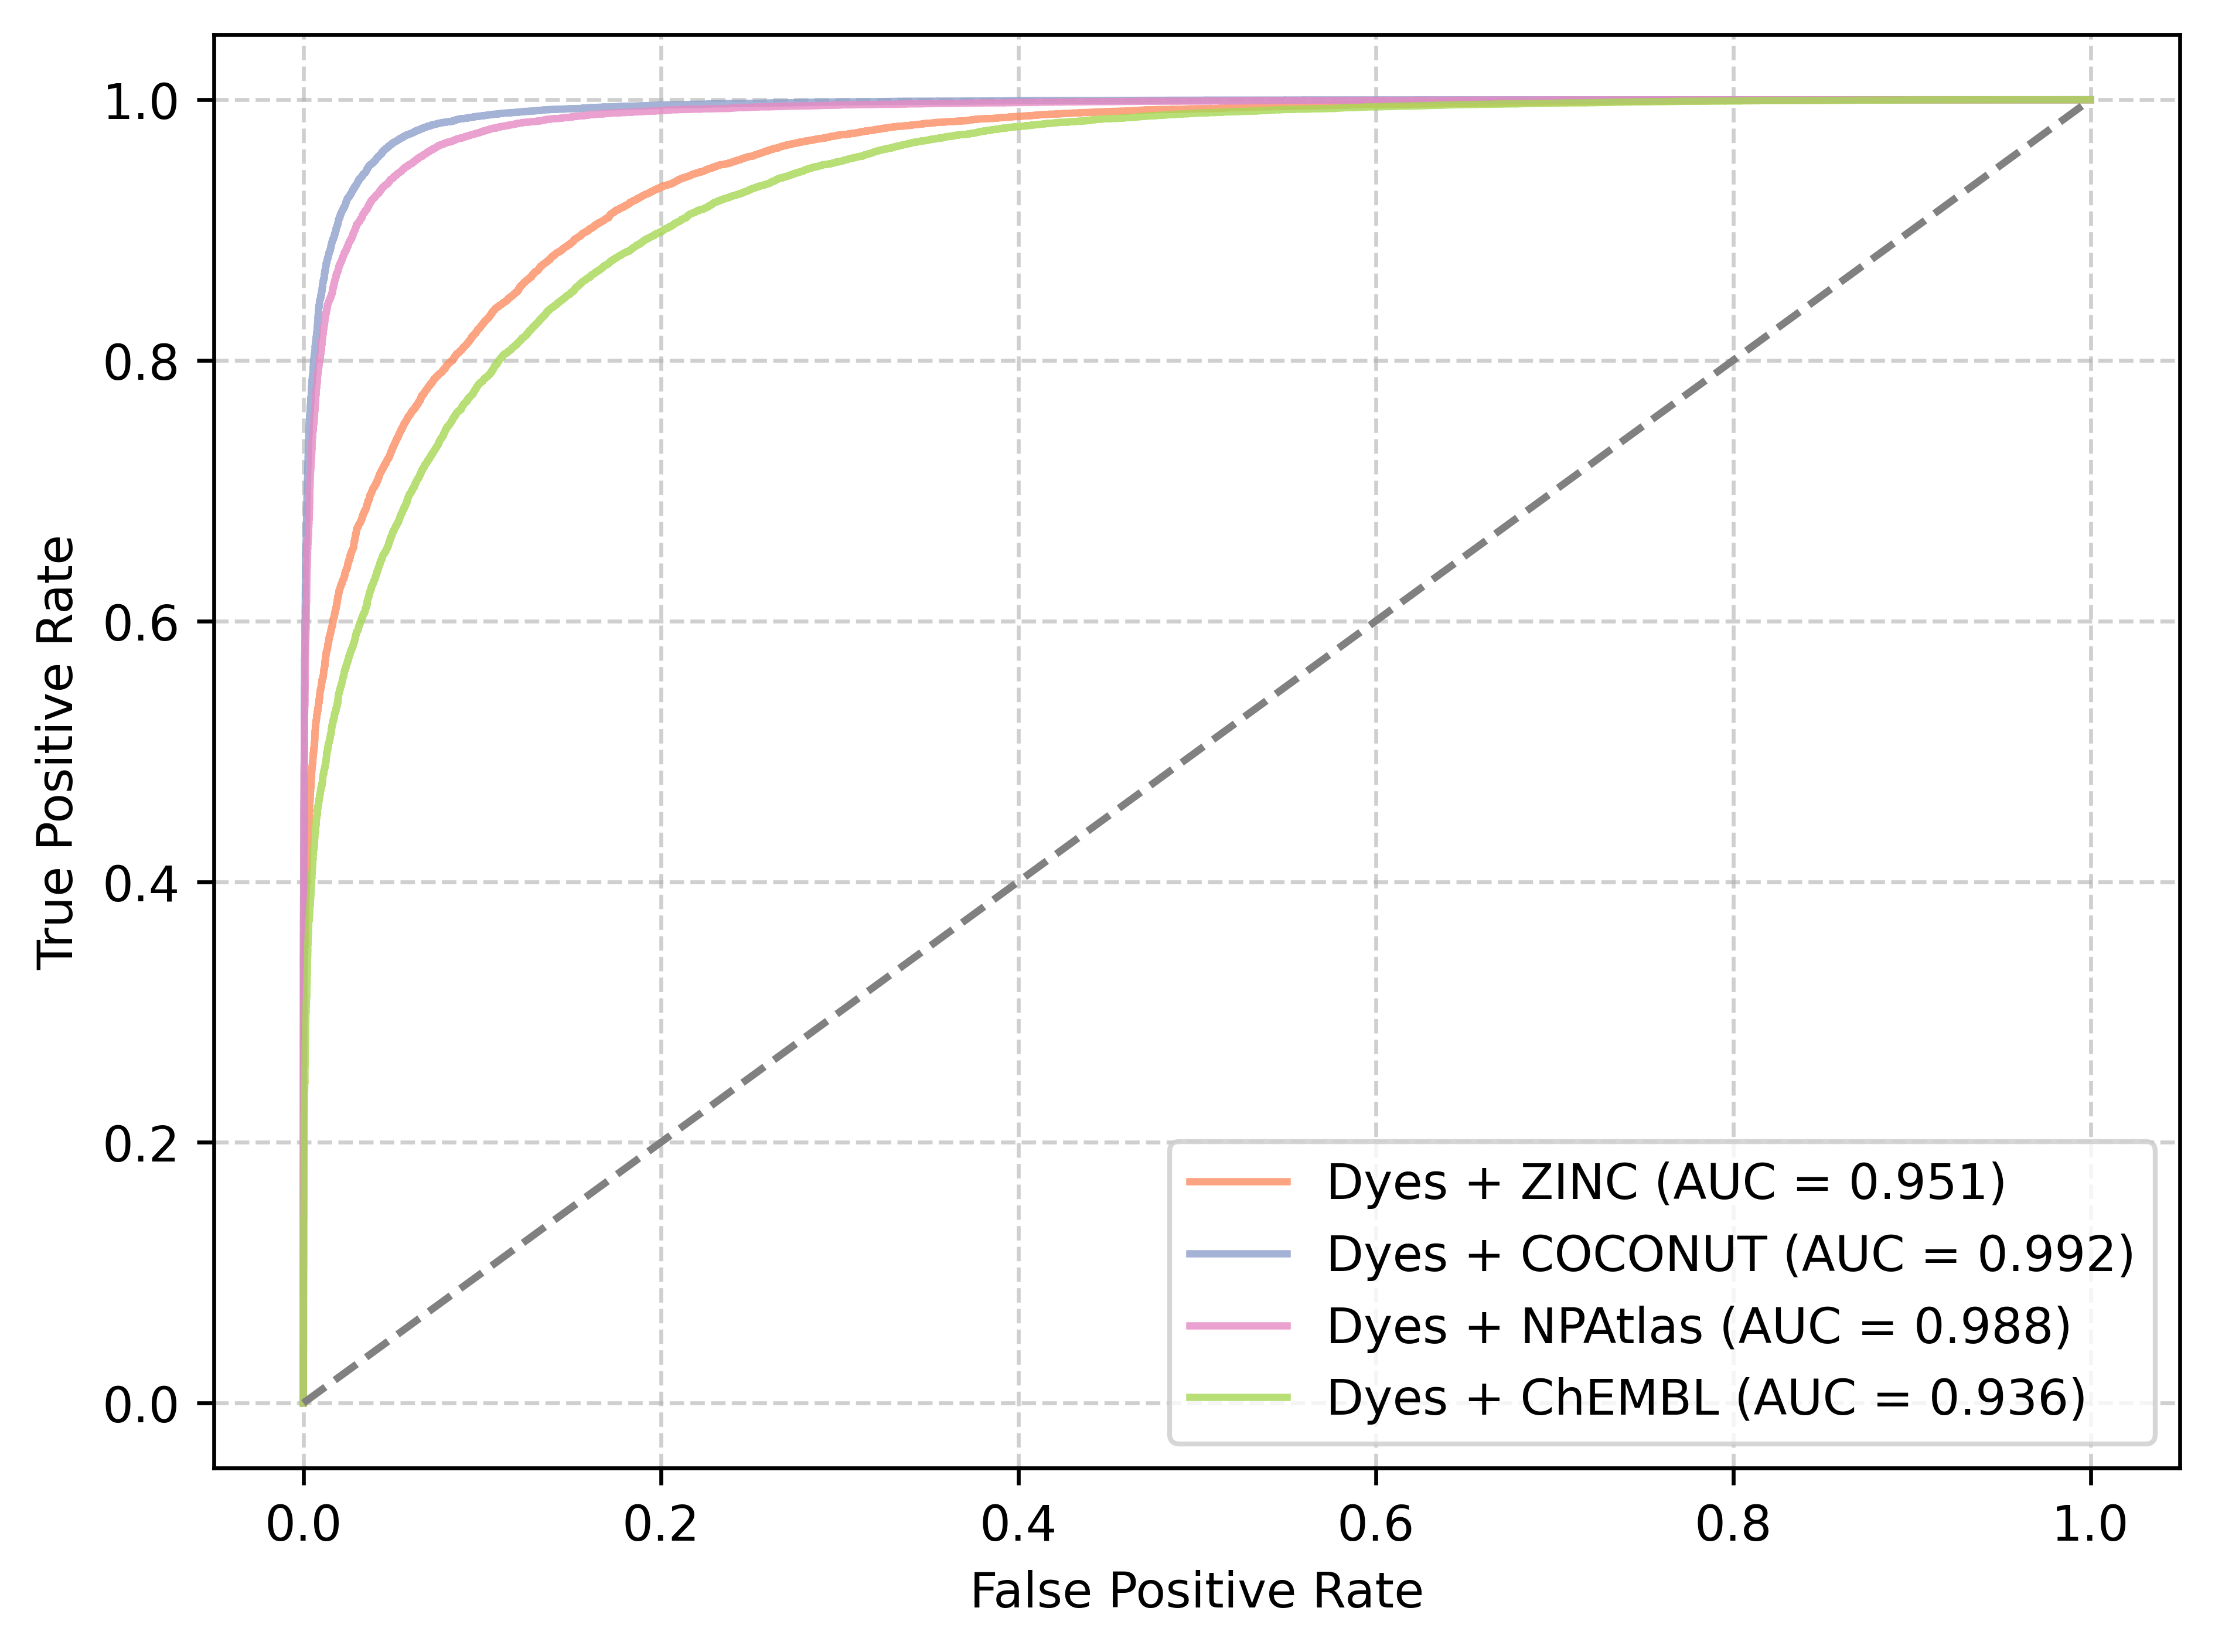

In [21]:
fig, ax = plt.subplots(dpi=600)
_plot_auc_roc(dyes_zinc_df.label.tolist(), dyes_zinc_df.predict_proba.tolist(), "Dyes + ZINC", ax, colors[1])
_plot_auc_roc(dyes_coconut_df.label.tolist(), dyes_coconut_df.predict_proba.tolist(), "Dyes + COCONUT", ax, colors[2])
_plot_auc_roc(dyes_npatlas_df.label.tolist(), dyes_npatlas_df.predict_proba.tolist(), "Dyes + NPAtlas", ax, colors[3])
_plot_auc_roc(dyes_chembl_df.label.tolist(), dyes_chembl_df.predict_proba.tolist(), "Dyes + ChEMBL", ax, colors[4])

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # 随机线
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()